# Simulating speckle in an image
Python implementation from the Mathematica implementation in the appendix (p.371) of the book "Speckle phenomena in optics, theory and applications", Joseph W. Goodman, 2007 by Ben Roberts & Company

𝐼_𝑠𝑝𝑒𝑐𝑘𝑙𝑒 (𝑥,𝑦)= |𝐹^(−1) {𝐹{𝐼_𝑠𝑜𝑢𝑟𝑐𝑒 (𝑥,𝑦).𝑒^𝑗𝜑(𝑥,𝑦)  }.〖𝑟𝑒𝑐𝑡〗_𝑑 (𝑥,𝑦)}|

⇔  𝐼_𝑠𝑝𝑒𝑐𝑘𝑙𝑒 (𝑥,𝑦)= |𝐼_𝑠𝑜𝑢𝑟𝑐𝑒 (𝑥,𝑦).𝑒^𝑗𝜑(𝑥,𝑦) ∗𝐹^(−1) {〖𝑟𝑒𝑐𝑡〗_𝑑 (𝑥,𝑦)}|

⇔  𝐼_𝑠𝑝𝑒𝑐𝑘𝑙𝑒 (𝑥,𝑦)= |𝐼_𝑠𝑜𝑢𝑟𝑐𝑒 (𝑥,𝑦).𝑒^𝑗𝜑(𝑥,𝑦) ∗〖𝑠𝑖𝑛𝑐〗_𝑑 (𝑥,𝑦)|

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Functions definition

In [2]:
# circle function
def circle(r):
    if (r<=1):
        return 1
    return 0

In [3]:
# rectangle function
def rect(x):
    if (x<1/2 and x>=-1/2):
        return 1
    return 0

In [4]:
# smooth circle function
eps=0.01
def circle(x):
    # Tukey window, smooth
    if (x<1-eps/2 and x>=eps/2):
        return 1
    elif (x>=0 and x<eps/2):
        return 0.5*(1-np.cos((2*np.pi*x)/eps))
    elif (x<1 and x>=1-eps/2):
        return 0.5*(1-np.cos((2*np.pi*(1-x))/eps))
    return 0

In [5]:
# smooth rectangle function
eps=0.01
def rect(x):
    # Tukey window, smooth
    if (x<1/2-eps/2 and x>=-1/2+eps/2):
        return 1
    elif (x>=-1/2 and x<-1/2+eps/2):
        return 0.5*(1-np.cos((2*np.pi*x)/eps))
    elif (x<1/2 and x>=1/2-eps/2):
        return 0.5*(1-np.cos((2*np.pi*(1-x))/eps))
    return 0

In [73]:
# all together: speckle function
def speckle (image, k):
    # image: 2D array image, with same width and height dimensions
    # k: number of samples per speckles
    n = image.shape[0]
    m = image.shape[1]
    r0 = (0.5*n+0.5*m)/k # radius of the lens speckle function in pixels

    bandpass = np.zeros((n,m)) # define circular pupil of the lens
    for i in range (1,n+1):
        for l in range (1,m+1):
            bandpass[i-1,l-1]=circle(np.sqrt((i-n/2)**2+(l-m/2)**2)/r0)

    pupilfield=bandpass*np.fft.fft2(image) # calculate the field transmitted by the lens pupil
    for i in range (pupilfield.shape[0]):
        for l in range (pupilfield.shape[1]):
            pupilfield[i,l]=pupilfield[i,l].conjugate()

    imagefield=np.fft.ifft2(pupilfield) # calculate the image field
    inv=np.fliplr(imagefield[:,1:])
    inv2=np.flipud(imagefield[1:,:])
    imagefield[:,1:]=inv
    imagefield[1:,:]=inv2

    imageintensity=abs(imagefield)**2 # calculate the image intensity
    combine = abs(image - 4*imagefield)**2
    #combine = image-16*imageintensity
    
    return imageintensity, combine

# Removal of speckle on CT image

In [22]:
import cv2
from scipy import ndimage

In [17]:
def crimmins(data):
    new_image = data.copy()
    nrow = len(data)
    ncol = len(data[0])
    
    # Dark pixel adjustment
    
    # First Step
    # N-S
    for i in range(1, nrow):
        for j in range(ncol):
            if data[i-1,j] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if data[i,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow):
        for j in range(1, ncol):
            if data[i-1,j-1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    #NE-SW
    for i in range(1, nrow):
        for j in range(ncol-1):
            if data[i-1,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i-1,j] > data[i,j]) and (data[i,j] <= data[i+1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] > data[i,j]) and (data[i,j] <= data[i,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j-1] > data[i,j]) and (data[i,j] <= data[i+1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j+1] > data[i,j]) and (data[i,j] <= data[i+1,j-1]):
                new_image[i,j] += 1
    data = new_image
    #Third Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i+1,j] > data[i,j]) and (data[i,j] <= data[i-1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j-1] > data[i,j]) and (data[i,j] <= data[i,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j+1] > data[i,j]) and (data[i,j] <= data[i-1,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j-1] > data[i,j]) and (data[i,j] <= data[i-1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    
    # Light pixel adjustment
    
    # First Step
    # N-S
    for i in range(1,nrow):
        for j in range(ncol):
            if (data[i-1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if (data[i,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow):
        for j in range(1,ncol):
            if (data[i-1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow):
        for j in range(ncol-1):
            if (data[i-1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i-1,j] < data[i,j]) and (data[i,j] >= data[i+1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] < data[i,j]) and (data[i,j] >= data[i,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j-1] < data[i,j]) and (data[i,j] >= data[i+1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j+1] < data[i,j]) and (data[i,j] >= data[i+1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # Third Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i+1,j] < data[i,j]) and (data[i,j] >= data[i-1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol-1):
            if (data[i,j-1] < data[i,j]) and (data[i,j] >= data[i,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j+1] < data[i,j]) and (data[i,j] >= data[i-1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j-1] < data[i,j]) and (data[i,j] >= data[i-1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    return new_image.copy()

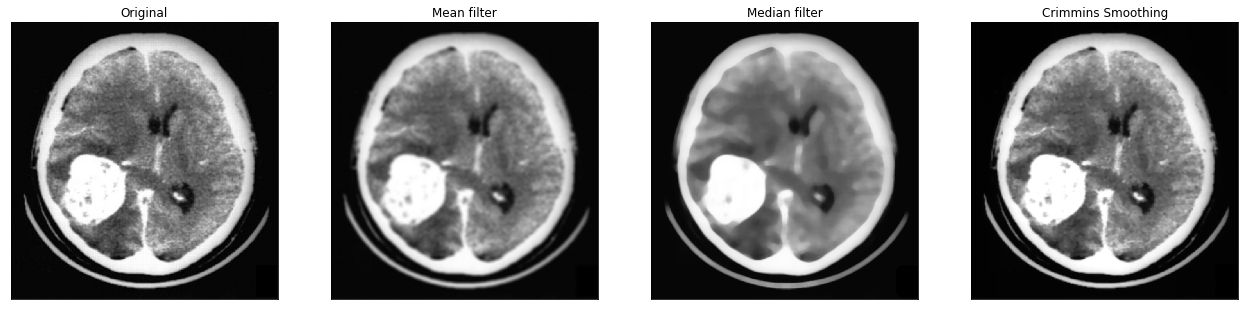

In [27]:
img = 'CT_brain_tumor.PNG'
image2=np.array(Image.open('images/'+img).convert('RGB'))
figure_size = 9
#mean filter
new_image = cv2.blur(image2,(figure_size, figure_size))
#median filter
result = ndimage.median_filter(image2, size=20)
#crimmins smoothing
crimmins_image = crimmins(image2.transpose()[0])

plt.figure(figsize=(22,6))
plt.subplot(141), plt.imshow(image2, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(142), plt.imshow(new_image, cmap='gray'),plt.title('Mean filter')
plt.xticks([]), plt.yticks([])
plt.subplot(143), plt.imshow(result, cmap='gray'),plt.title('Median filter')
plt.xticks([]), plt.yticks([])
plt.subplot(144), plt.imshow(crimmins_image.transpose(), cmap='gray'),plt.title('Crimmins Smoothing')
plt.xticks([]), plt.yticks([])
plt.show()

In [28]:
# for saving            
if not os.path.exists('test/'):
    os.makedirs('test/')
cv2.imwrite('test/'+img, image2)
cv2.imwrite('test/mean_'+img, new_image)
cv2.imwrite('test/median_'+img, result)
cv2.imwrite('test/crimmins_'+img, crimmins_image.transpose())

True

# Generation of speckles

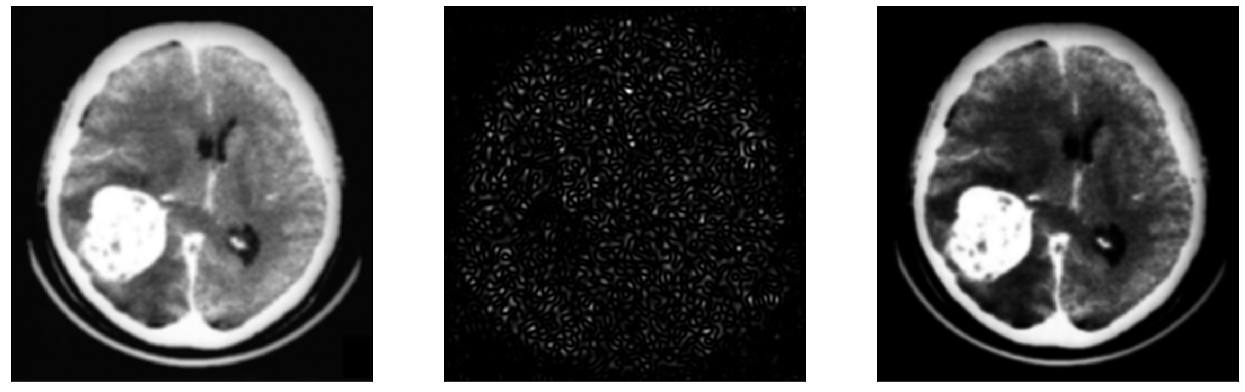

In [79]:
image=Image.open('test/mean_CT_brain_tumor.PNG').convert('L')
hola = np.array(image)
sp_hola, comb_hola=speckle(hola, 16)
plt.figure(figsize=(22,14))
plt.subplot(131)
plt.imshow(hola, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(sp_hola, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(comb_hola, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

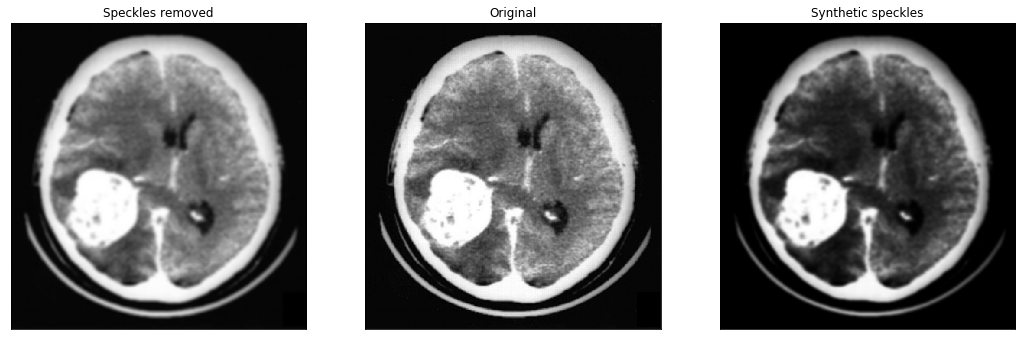

In [76]:
plt.figure(figsize=(18,10))
plt.subplot(131), plt.imshow(image, cmap="gray"), plt.title('Speckles removed')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(image2, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(comb_hola, cmap="gray"), plt.title('Synthetic speckles')
plt.xticks([]), plt.yticks([])
plt.show()

# Speckle test on syntetic image

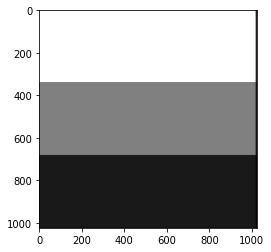

In [277]:
n=1024
k=16
r0=n/k
objectintensity = np.zeros((n,n))
for i in range (1,n+1):
    for j in range (1,n+1):
        objectintensity[i-1,j-1]=(1.*rect((i-n/6)/(n/3))+0.5*rect((i-n/2)/(n/3))+0.1*rect((i-5*n/6)/(n/3)))*rect(j/(2*n))
randomfield = np.zeros((n,n), complex)
for i in range(1,n+1):
    for l in range(1,n+1):
        a=complex(0, 2*np.pi*np.random.random_sample())
        randomfield[i-1,l-1]= np.exp(a)
scatterfield = np.sqrt(objectintensity)*randomfield

plt.imshow(abs(scatterfield)**2, cmap="gray")
plt.show()

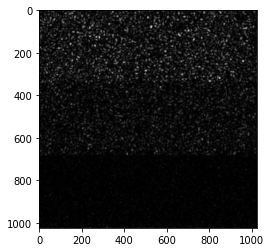

In [278]:
bandpass = np.zeros((n,n))
for i in range (1,n+1):
    for l in range (1,n+1):
        bandpass[i-1,l-1]=circle(np.sqrt((i-n/2)**2+(l-n/2)**2)/r0)

pupilfield=bandpass*np.fft.fft2(scatterfield)
for i in range (pupilfield.shape[0]):
    for l in range (pupilfield.shape[1]):
        pupilfield[i,l]=pupilfield[i,l].conjugate()

imagefield=np.fft.ifft2(pupilfield)
inv=np.fliplr(imagefield[:,1:])
inv2=np.flipud(imagefield[1:,:])
imagefield[:,1:]=inv
imagefield[1:,:]=inv2

imageintensity=abs(imagefield)**2

plt.imshow(imageintensity, cmap="gray")
plt.show()

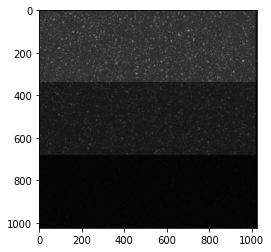

In [279]:
combine = abs(scatterfield + 4*imagefield)**2
plt.imshow(combine, cmap='gray')

# Tests fourier transform

In [160]:
racine=np.sqrt(2)
b=np.fft.ifft(np.array([1+2j, 3+4j]))
for i in range (2):
    b[i]=b[i]*np.sqrt(2)
b

array([ 2.82842712+4.24264069j, -1.41421356-1.41421356j])

In [152]:
a=np.fft.fft(np.array([1,1,2,2,1,1,0,0]))
for i in range (8):
    a[i]=a[i]/np.sqrt(8)
a

array([ 2.82842712+0.j        , -0.5       -1.20710678j,
        0.        +0.j        ,  0.5       +0.20710678j,
        0.        +0.j        ,  0.5       -0.20710678j,
        0.        +0.j        , -0.5       +1.20710678j])

In [232]:
#c=np.fft.fft2(np.array([[0,1,3],[2,0,5]]))
array_test=np.array([[4-2j, -1, 2+5j, -3+1j],[4+2j, -1, 2-5j, -3+1j],[-5-2j,1-3j,1+1j, -2+3j]])
k=array_test.shape[0]
m=array_test.shape[1]
for i in range (k):
    for l in range (m):
        array_test[i,l]=array_test[i,l]*np.sqrt(k*m)
c=np.fft.ifft2(array_test)
inv=np.fliplr(c[:,1:])
c[:,1:]=inv
inv2=np.flipud(c[1:,:])
c[1:,:]=inv2
c

array([[-0.28867513+0.28867513j, -2.88675135-2.88675135j,
         4.90747729-0.8660254j ,  1.73205081+1.15470054j],
       [ 0.76036297-0.16228676j,  4.62638837-5.70373864j,
         1.12638837-1.95096189j,  2.6830127 -3.49241378j],
       [ 1.26036297+3.33771324j, -0.87361163+0.79626136j,
         2.62638837+4.54903811j, -1.8169873 -1.99241378j]])

# Test with differenciable window
See scipy window types: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html

Moving window (to start): https://stackoverflow.com/questions/8174467/vectorized-moving-window-on-2d-array-in-numpy

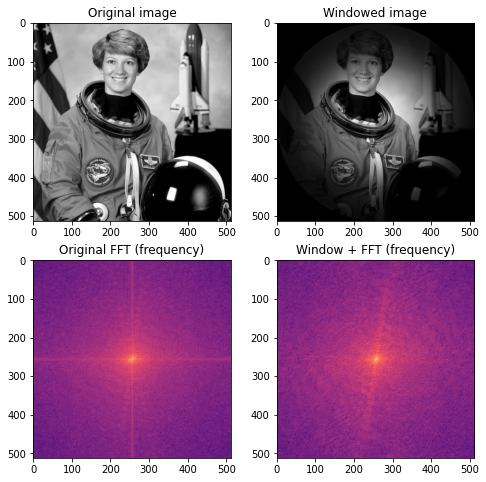

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft2, fftshift
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.data import astronaut
from skimage.filters import window

image = img_as_float(rgb2gray(astronaut()))

wimage = image * window('hamming', image.shape)

image_f = np.abs(fftshift(fft2(image)))
wimage_f = np.abs(fftshift(fft2(wimage)))

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original image")
ax[0].imshow(image, cmap='gray')
ax[1].set_title("Windowed image")
ax[1].imshow(wimage, cmap='gray')
ax[2].set_title("Original FFT (frequency)")
ax[2].imshow(np.log(image_f), cmap='magma')
ax[3].set_title("Window + FFT (frequency)")
ax[3].imshow(np.log(wimage_f), cmap='magma')
plt.show()

To test:
- hamming window
- h = hamming(n)
- ham2d = sqrt(outer(h,h))